In [1]:
# One of the most common and popular methods for reducing the dimensionality of a dataset
# is Principal Component Analysis, or PCA. The method relies on finding the most important
# ORTHOGONAL (ie uncorrelated) components of the dataset.
# The steps for PCA are as follows:
# 1. Standardize the d-dimensional input dataset X
# 2. Construct the covariance matrix (TODO: check this up)
# 3. Decompose the covariance matrix into eigenvectors and eigenvalues (see https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)
# 4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors
# 5. Select k eigenvectors corresponding to the largest k eigenvalues,
#    where k is the dimensionality of the new feature subspace (k < d)
# 6. Construct a projection matrix W from the top k eigenvectors
# 7. Transform the d-dimensional input dataset X using the projection matrix W to obtain the new
#    k-dimensional feature subspace.
#
# Now we are going to implement PCA on our own, to understand exactly how the method functions.
#
# As a first thing, we will implement the *first four steps of the PCA*.

import pandas as pd
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
                     header=None)
# Split into 70% training and 30% testing

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Standardize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [7]:
# Step two: construct the covariance matrix
# This is a d x d matrix (d being the number of features), which stores the pairwise covariance between
# the different features.
# In general, the covariance between two features x_j and x_k can be calculated as follows:
# var_jk = 1/n * sum(i=1,n)[ (x_j(i) - mean_j) * (x_k(i) - mean_k) ]
# If the dataset has been standardized, by definition mean_k = mean_j = 0, so we can rewrite as
# var_jk = 1/n * sum(i=1, n)[x_j(i) * x_k(i)]
# 
# Given a covariance matrix, its eigen-vectors represent the directions of maximum variance, and the
# eigenvalues, the magnitude.
# An eigenvector v satisfies the following condition:
# SIGMA v = LAMBDA v
# with LAMBDA being a scalar, ie our EIGENVALUE.

import numpy as np
# We are lazy, so we are just going to us NumPY to calculate the Covariance Matrix
cov_mat = np.cov(X_train_std.T)
# Now we are going again to use NumPY to calculate the eigen-values and eigen-vectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals = np.sort(eigen_vals)
print("\nEigenvalues \n{}".format(eigen_vals))

# The eigh function (EIGen decomposition for Hermetian matrices) will function only on symmetric matrices
# but is guaranteed to always find real, rather than imaginary, eigen-values.
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
eigen_vals = np.sort(eigen_vals)
print("\nEigenvalues \n{}".format(eigen_vals))
print()
print("Total sum of the eigen values:", eigen_vals.sum())


Eigenvalues 
[0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]

Eigenvalues 
[0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]

Total sum of the eigen values: 13.105691056910567


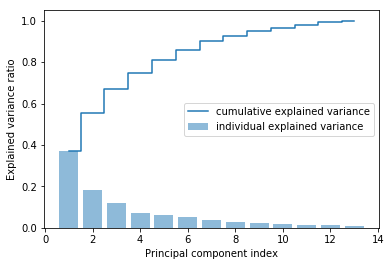

In [9]:
# In this context, the eigenvalues can be interpreted as the magnitude of the variance explained by the
# corresponding eigenvector. The **variance explained ratio of an eigenvalue** is the ratio of the eigenvalue
# over the total sum of the eigenvalues.
# Let us plot it!

import matplotlib.pyplot as plt

tot = eigen_vals.sum()
var_exp = np.array([(i/tot) for i in sorted(eigen_vals, reverse=True)])
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,14), var_exp, alpha=0.5, align="center", label="individual explained variance")
plt.step(range(1,14), cum_var_exp, where="mid", label="cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend()
plt.show()


In [10]:
# Now that we have obtained the covariance matrix, and its eigen components, time to map the dataset
# onto the reduced dimensionality space.
# 5. Select k eigenvectors, in decreasing order
# 6. Construct a projection matrix W
# 7. Transform the input dataset X into the W space

# 5. Make an ordered list of tuples of eigen-values and eigen-vectors

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Sort
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [12]:
# Select the first two vectors, for illustration purposes

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print("Matrix W:\n", w)

# Now project the original feature space onto the reduced dimensional matrix using w

X_train_pca = X_train_std.dot(w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


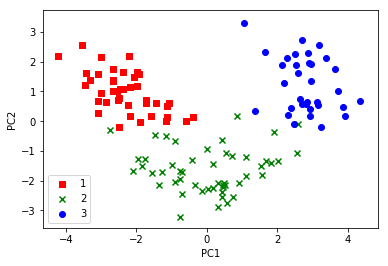

In [14]:
# Finally let us visualise it all

colors = ["r", "g", "b"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
               c=c, label=l, marker=m)
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="lower left")
plt.show()

# In this case we are lucky: PCA does not use the class labels in any way - it is an UNSUPERVISED 
# technique - yet the PCA-reduced data would well be separable through a simple linear classifier

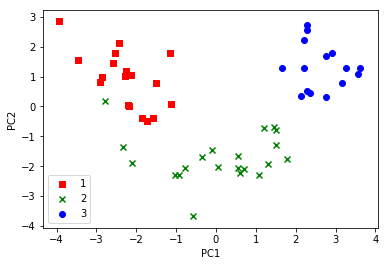

In [17]:
# For curiosity's sake, now let's try with the test partition ...

X_test_pca = X_test_std.dot(w)

colors = ["r", "g", "b"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_test), colors, markers):
    plt.scatter(X_test_pca[y_test==l, 0],
                X_test_pca[y_test==l, 1],
                c=c, label=l, marker=m)
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="lower left")
plt.show()

# Still lucky: the evident linear separation of the three classes holds.

In [18]:
## Now that we have a grasp of how PCA functions, time to use the more efficient version
## Present in SKLearn. 

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Meshgrid: this utility 
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                   y=X[ y== cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor="black")
    return

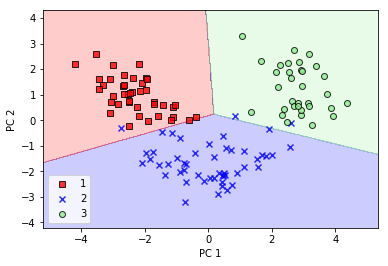

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

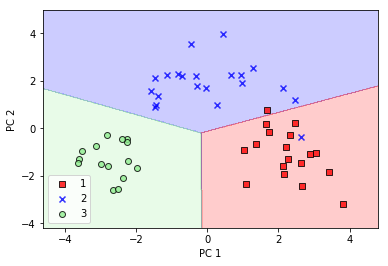

In [23]:
# Let us plot the same for the test data

lr.fit(X_test_pca, y_test)
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()